In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy.clients.fdsn import Client
from obspy.core.inventory.inventory import Inventory
from obspy.signal.filter import envelope, lowpass
from obspy.clients.fdsn.header import FDSNNoDataException
from obspy import read, read_inventory
client = Client("IRIS")



In [2]:
EV_NAME = 'SewardGlacier'
# Earthquake variables
# eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
# eq = uf.Earthquake(f'grids/{EV_NAME}.xml')
eq_lat = 59.8935
eq_lon = -153.1961
eq_dep = 119.3


In [3]:

# ObsPY variables
station_data = {}

or_time = '2015-07-29T02:35:59'
or_time = UTCDateTime(or_time)
starttime = or_time
endtime = or_time + 360

network = 'AK,NP,TA,AV'
stations = 'P19K,AUJA,SLK,SSN,CAPN,8037,K220,FIRE,K204,CNP,CAPN'
# stations = stations.split(',')

channel = '?N?'
location = '*'


In [4]:
# Download data
st = client.get_waveforms(network=network, station=stations, location='*', channel=channel, starttime=starttime, endtime=endtime)
inv = client.get_stations(network=network, station=stations, location="*", channel=channel, starttime=starttime,
                                         endtime=endtime, level='response')


In [5]:
# EQ related information
for net in inv:    
    for station in net:
        name = station.code
        lat = station.latitude
        lon = station.longitude
        # Find closest grid point in ShakeMap grid and pga
        # subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
        # nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
        # pga = eq.pga[nearest_index, 0]
        # Calculate epicentral and hypocentral distance, and first-arrival times
        epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
        hypo_dist = (epi_dist**2 + eq_dep**2)**.5
        # p_arr = hypo_dist/eq.vel_p
        # s_arr = hypo_dist/eq.vel_s
        # surf_arr = hypo_dist/eq.vel_surf
        # Save the info into the data dict
        station_data[name] = {'lat': lat,
                              'lon': lon,
                              'epi_dist': epi_dist,
                              'hypo_dist': hypo_dist,
                              # 'pga': pga,
                              # 'p_arr': p_arr,
                              # 's_arr': s_arr,
                              # 'surf_arr': surf_arr
                             }


In [6]:
#test cell for printing stuff
print(inv)
print(st)


Inventory created at 2023-04-05T23:55:06.171700Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2015-07-29...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			AK, NP
		Stations (6):
			AK.CNP (China Poot, AK, USA)
			AK.FIRE (Fire Island, AK, USA)
			AK.K204 (Anchorage, Signature Flight Support, AK, USA)
			AK.K220 (Anchorage, Kincaid Park, AK, USA)
			AK.SSN (Susitna, AK, USA)
			NP.8037 (AK:Anchorage;NOAA Weather Fac)
		Channels (18):
			AK.CNP..BNZ, AK.CNP..BNN, AK.CNP..BNE, AK.FIRE..HNZ, AK.FIRE..HNN, 
			AK.FIRE..HNE, AK.K204..HNZ, AK.K204..HNN, AK.K204..HNE, 
			AK.K220..HNZ, AK.K220..HNN, AK.K220..HNE, AK.SSN..BNZ, AK.SSN..BNN
			AK.SSN..BNE, NP.8037..HNZ, NP.8037..HNN, NP.8037..HNE
9 Trace(s) in Stream:
AK.CNP..BNE  | 2015-07-29T02:35:59.008400Z - 2015-07-29T02:41:58.988400Z | 50.0 Hz, 18000 samples
AK.CNP..BNN  | 2015-07-29T02:35:59.008400Z - 2015-07-29T02:41:58.988400Z | 50.

Number of traces: 9


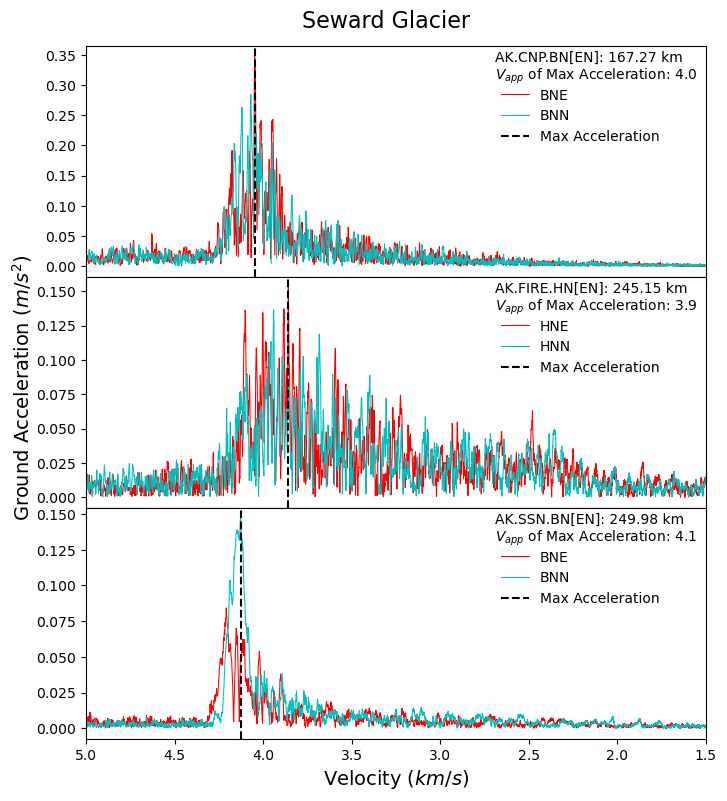

In [7]:
n_tr = len(st)
stringtotext = 'event, stationcode, hypodist, maxacc, vapp'
print('Number of traces:', n_tr)
alpha = 1
lw = 0.75
fs=14
vapp_list = []
st1 = st.copy()
# for i in len(st1):
#     tr = st1[i]
#     sample_rate = tr.stats.sampling_rate
    
    
st1.attach_response(inv)
st1 = st1.remove_response(output='ACC')

fig, ax = plt.subplots(nrows=n_tr // 3, sharex=True, figsize=(8,n_tr))
fig.subplots_adjust(hspace=0)
for i in range(n_tr // 3):
    sample = st1[i*3].stats.channel[0]
    chan = sample + channel[1] + '[EN]'

    code = st1[i*3].stats.station
    net = st1[i*3].stats.network
    distance = station_data[code]['hypo_dist']
    
    tr_e = st1[i*3].detrend('demean')
    tr_n = st1[i*3 + 1].detrend('demean')
    tr_z = st1[i*3 + 2].detrend('demean')
    
    env_e = envelope(tr_e.data)
    env_n = envelope(tr_n.data)
    env_z = envelope(tr_z.data)
    
    h_max_acc = 0
    h_max_ind = 0
    h_max_time = 0
    if np.max(env_e) >= np.max(env_n):
        h_max_ind = np.argmax(env_e)
        h_max_acc = np.max(env_n)
        h_max_time = tr_e.times()[h_max_ind]
    else:
        h_max_ind = np.argmax(env_n)
        h_max_acc = np.max(env_n)
        h_max_time = tr_n.times()[h_max_ind]
        
    # tr_e = st1[i*3]
    # tr_n = st1[i*3 + 1]
    # tr_z = st1[i*3 + 2]
    
    v_app_e = distance/tr_e.times()[1:]
    v_app_n = distance/tr_n.times()[1:]
    v_app_z = distance/tr_z.times()[1:]
    h_max_vapp = distance/h_max_time
    
    ax[i].plot(v_app_e, env_e[1:], c='r', label=tr_e.stats.channel, lw=lw, alpha=alpha)
    ax[i].plot(v_app_n, env_n[1:], c='c', label=tr_n.stats.channel, lw=lw, alpha=alpha)
    # ax[i].plot(v_app_z, env_z[1:], c='k', label=tr_z.stats.channel, lw=lw, alpha=alpha)    
    ax[i].axvline(h_max_vapp, ls='--', lw=2*lw, c='k', label='Max Acceleration')
    ax[i].text(.66, .98, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].text(.66, .91, r'$V_{app}$ of Max Acceleration: %.1f' % (np.round(h_max_vapp, 1)), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].legend(loc=(.66, .55), frameon=False, fancybox=False)
    # ax[i].set_title('%s: %.2f km' % (code, distance))
    vapp_list.append(h_max_vapp)
    stringtotext += '\n%s, %s, %.2f, %.2f, %.2f' % (EV_NAME, code, distance, h_max_acc, h_max_vapp)
# plt.xscale('log')
plt.xlim(5, 1.5)
plt.xlabel(r'Velocity $(km/s)$', fontsize=fs)
fig.text(0.03, 0.5, r'Ground Acceleration $(m/s^2)$', va='center', rotation='vertical', fontsize=fs)
fig.text(0.5, 0.9, 'Seward Glacier', ha='center', fontsize=fs+2)
plt.savefig(f'Plots/{EV_NAME}.pdf')
plt.show()


In [8]:
print(vapp_list)
print(stringtotext)

[4.04810475414991, 3.8578746738543295, 4.127773153842802]
event, stationcode, hypodist, maxacc, vapp
SewardGlacier, CNP, 167.27, 0.28, 4.05
SewardGlacier, FIRE, 245.15, 0.14, 3.86
SewardGlacier, SSN, 249.98, 0.15, 4.13


In [9]:
with open(f'Vapps/{EV_NAME}_vapps.txt', 'w') as file:
    file.write(stringtotext)

/Users/alexfozkos/opt/miniconda3/envs/ShakeMaps/lib/python3.9/site-packages/obspy/signal/filter.py:206: RuntimeWarning: invalid value encountered in sqrt
  data = (data ** 2 + hilb ** 2) ** 0.5
/Users/alexfozkos/opt/miniconda3/envs/ShakeMaps/lib/python3.9/site-packages/obspy/signal/filter.py:206: RuntimeWarning: invalid value encountered in sqrt
  data = (data ** 2 + hilb ** 2) ** 0.5


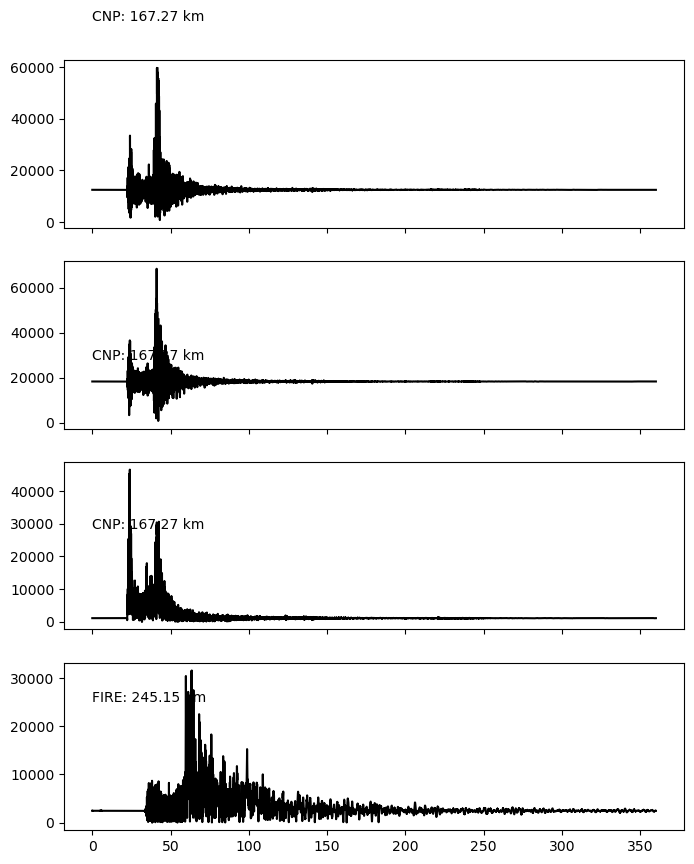

In [10]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,10))
for i in range(4):
    code = st1[i].stats.station
    distance = station_data[code]['hypo_dist']
    v_app = distance/st1[i].times()[1:]
    ax[i].plot(st1[i].times(), envelope(st[i].data), c='k')
    ax[i].text(0, np.max(st[i].data[1:])-1000, '%s: %.2f km' % (code, distance), va='top')

In [11]:
st[0].stats.sampling_rate

50.0

In [12]:
len(st)

9

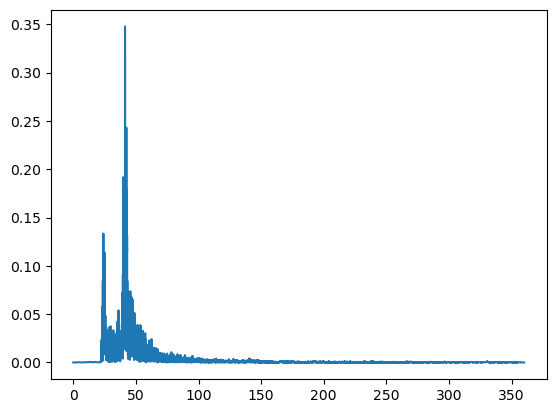

In [13]:
plt.figure()
plt.plot(st1[0].times(), envelope(st1[0].data))

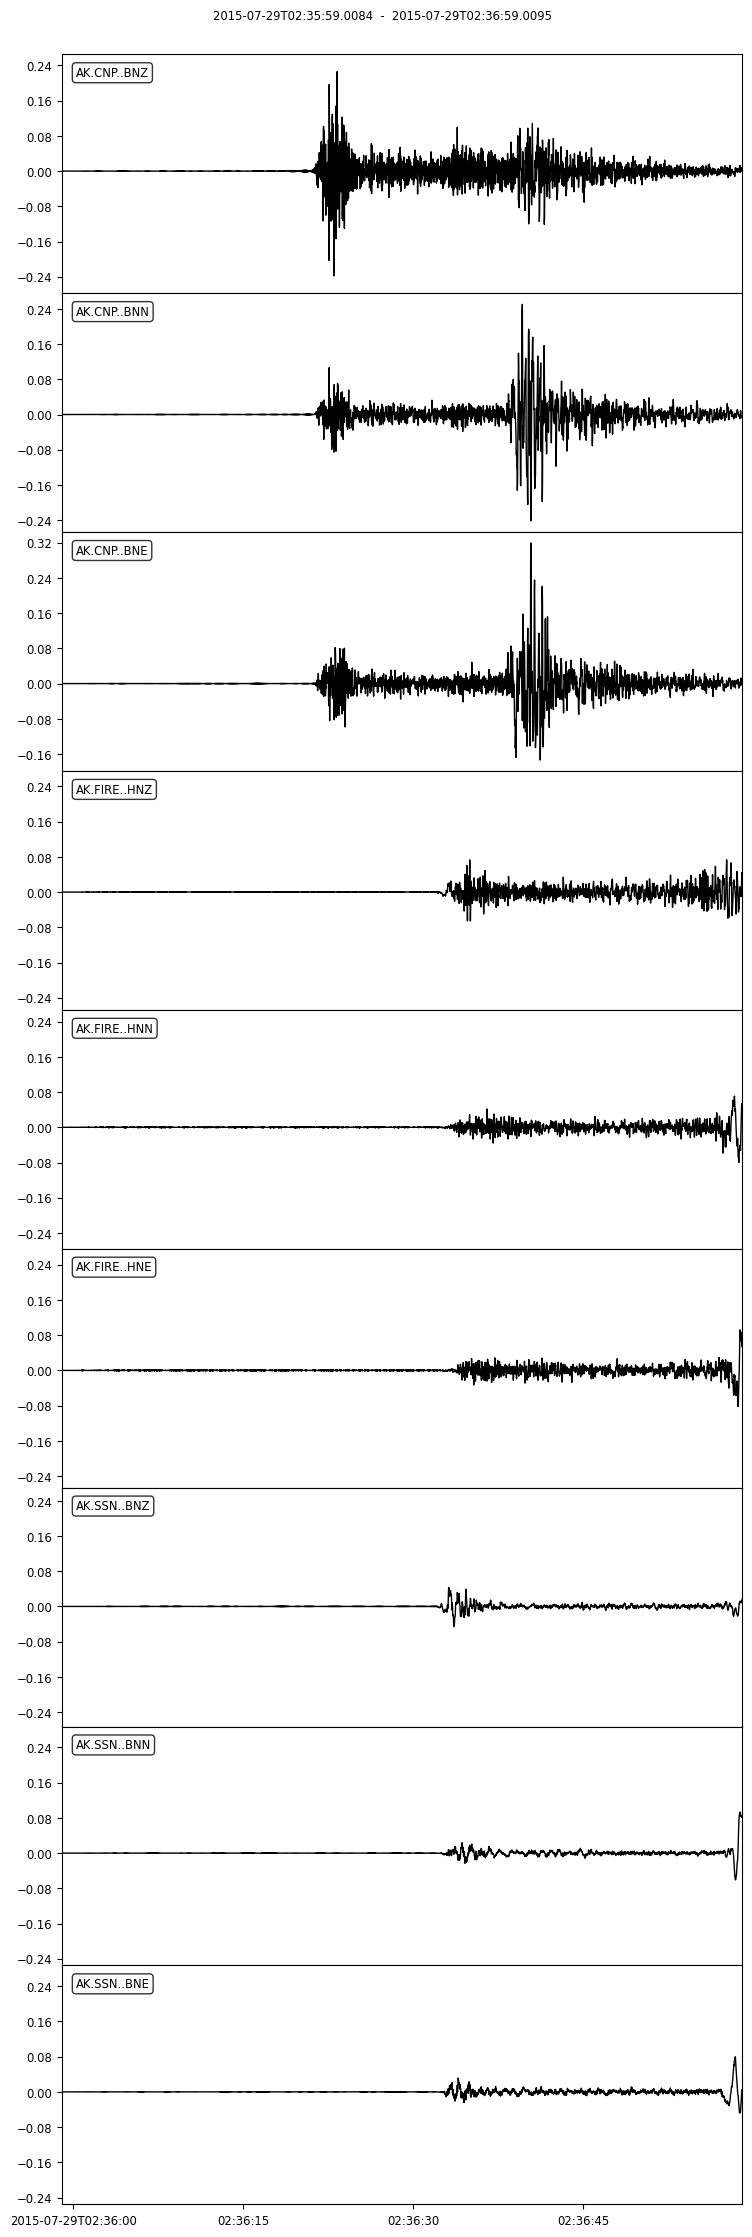

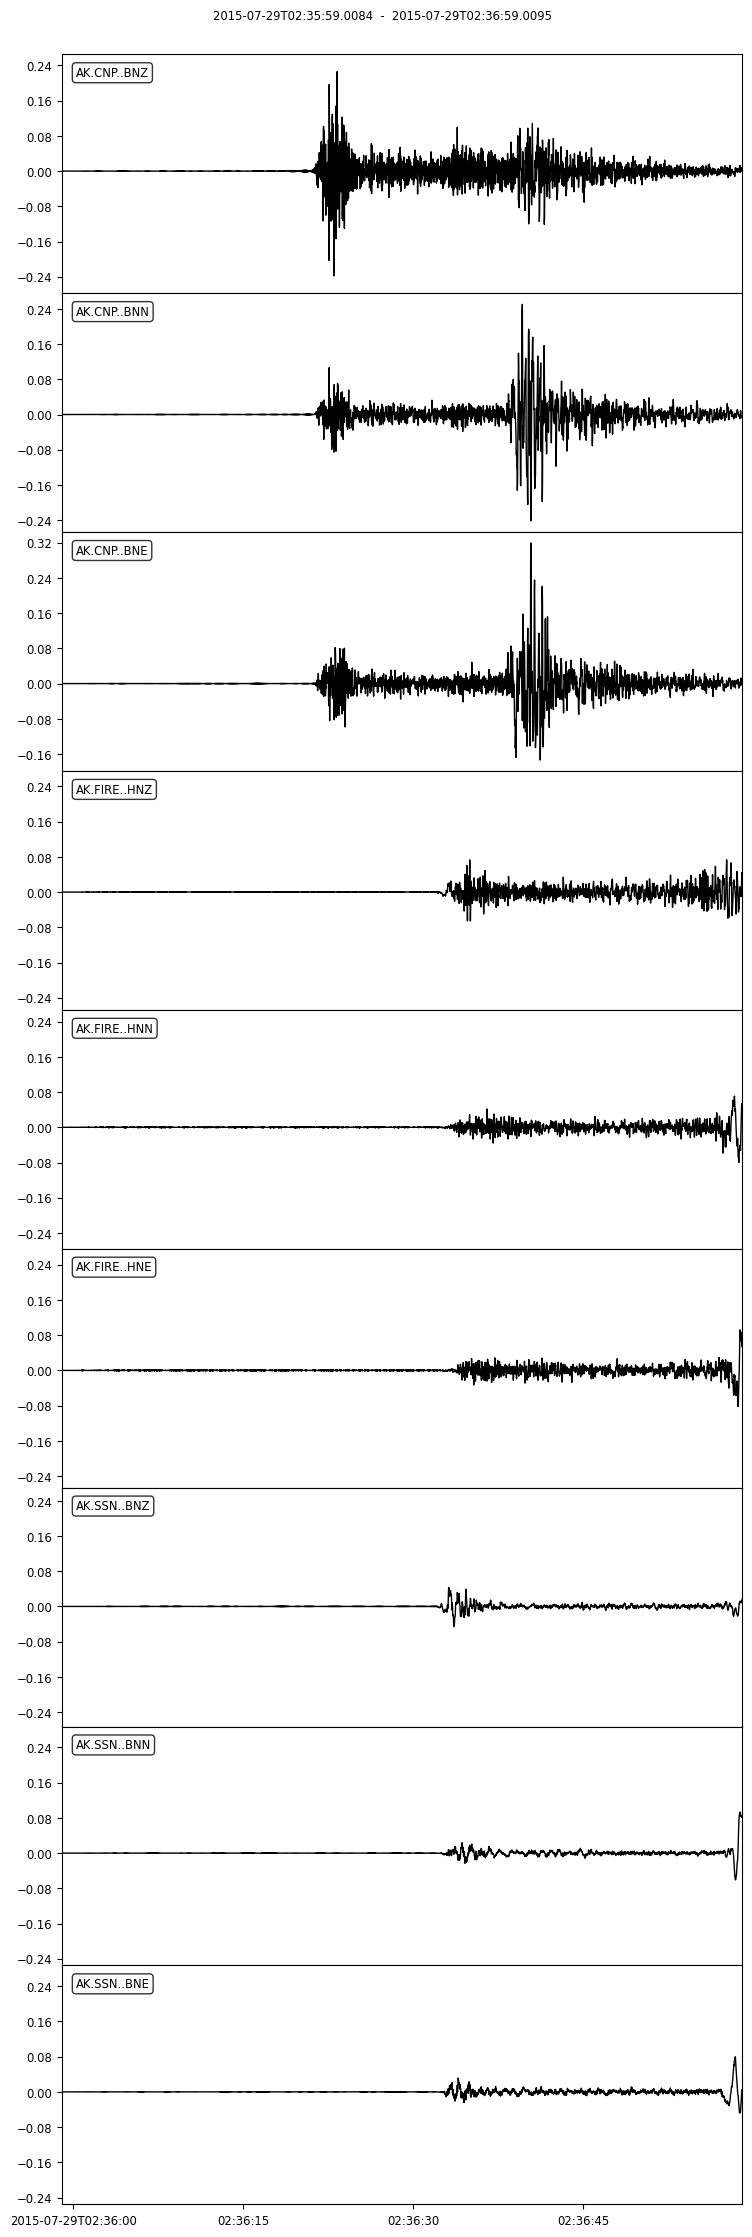

In [14]:
stt = st1.copy()
stt.trim(starttime=starttime+0, endtime=starttime+60)
stt.plot()

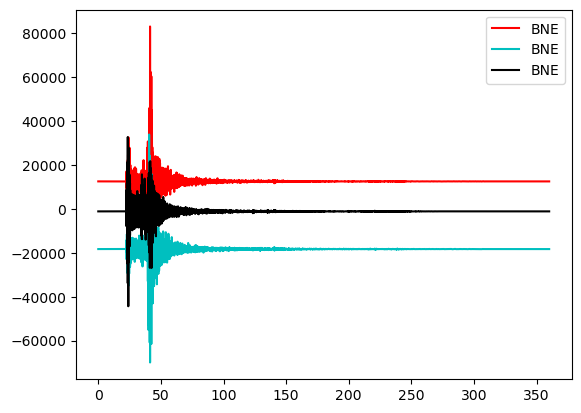

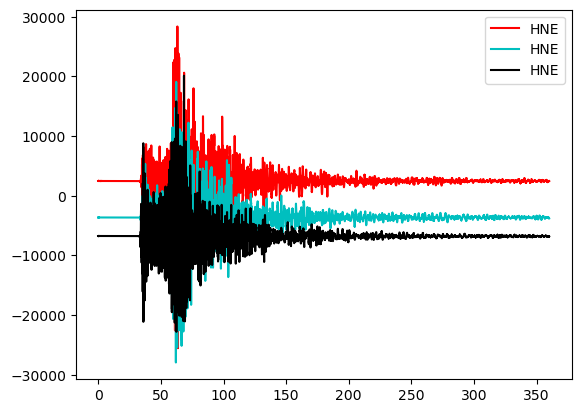

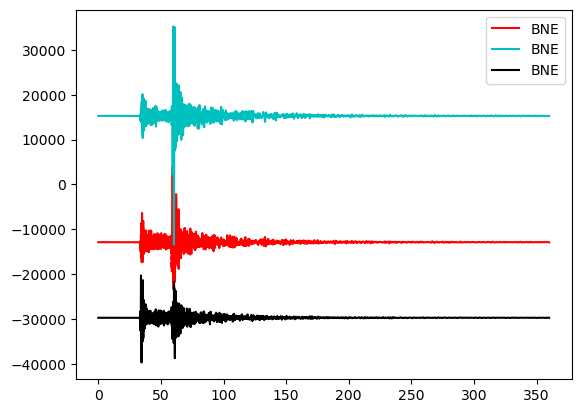

In [15]:
stt = st.copy()
stt.trim(starttime=starttime, endtime=endtime)

for i in range(len(stt)//3):
    plt.figure()
    # st[i].plot()
    code = stt[i*3].stats.station
    net = stt[i*3].stats.network
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    plt.plot(stt[i*3].times(), stt[i*3].data, c='r', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+1].times(), stt[i*3+1].data, c='c', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+2].times(), stt[i*3+2].data, c='k', label=stt[i*3].stats.channel)

    # plt.text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=plt.transAxes)
    plt.legend(loc='upper right')

In [16]:
st[0*3+1].times())

SyntaxError: unmatched ')' (265354340.py, line 1)

In [ ]:
st.plot()

In [ ]:
stime = UTCDateTime('2018-11-30T17:29:29.000Z')
st = client.get_waveforms('AK', 'K223', '?', 'BN?', starttime=starttime, endtime=endtime)
